<a href="https://colab.research.google.com/github/asegura4488/CienciaDatos/blob/main/Semana6/EstudioRedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
import seaborn as sns
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/Cursos/CursoCienciaDatos/Semana6')
!ls

Datos  EstudioRedNeuronal.ipynb


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC as KerasAUC

In [22]:
# Carga de Data
df = pd.read_csv('Datos/Churn_Modelling.csv')
#df

In [23]:
# Limpiar columnas no predictoras
for col in ['RowNumber', 'CustomerId', 'Surname']:
    df.drop(col, axis=1, inplace=True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [24]:
# La funcion a predecir
y = df['Exited'].astype(int)
# Feature engineering
x = df.drop(columns='Exited')

In [25]:
# one-hot encoding para las categoricas
X = pd.get_dummies(x, drop_first=True)
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,True,False,True


In [30]:
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [33]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Escalar todas las variables
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [37]:
# Modelo de Keras
model = Sequential([
    Dense(10,activation='relu', input_shape=(X_train_s.shape[1],)),
    Dropout(0.1),
    Dense(10,activation='relu'),
    Dropout(0.1),
    Dense(1,activation='sigmoid')
]
)

In [38]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', KerasAUC(name='auc')]
)

In [39]:
# Early stopping y entrenamiento
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(
    X_train_s,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5430 - auc: 0.5533 - loss: 0.6968 - val_accuracy: 0.7808 - val_auc: 0.5940 - val_loss: 0.5518
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7905 - auc: 0.5934 - loss: 0.5347 - val_accuracy: 0.7921 - val_auc: 0.6591 - val_loss: 0.4962
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7949 - auc: 0.6233 - loss: 0.5017 - val_accuracy: 0.7933 - val_auc: 0.7087 - val_loss: 0.4699
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7897 - auc: 0.6945 - loss: 0.4788 - val_accuracy: 0.7958 - val_auc: 0.7390 - val_loss: 0.4533
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - auc: 0.7074 - loss: 0.4582 - val_accuracy: 0.7992 - val_auc: 0.7552 - val_loss: 0.4428
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - auc: 0.7292 - loss: 0.4562 - val_accuracy: 0.8017 - val_auc: 0.7658 - val_loss: 0.4357
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

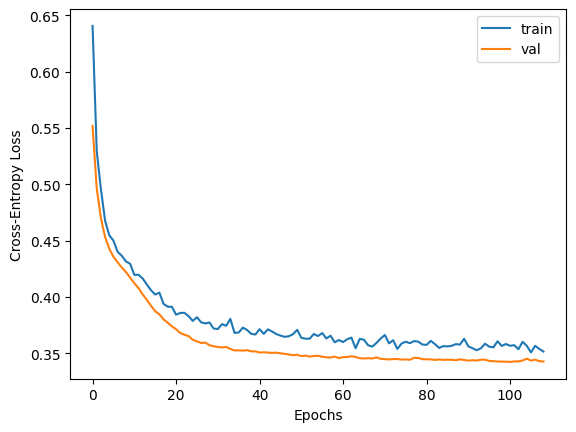

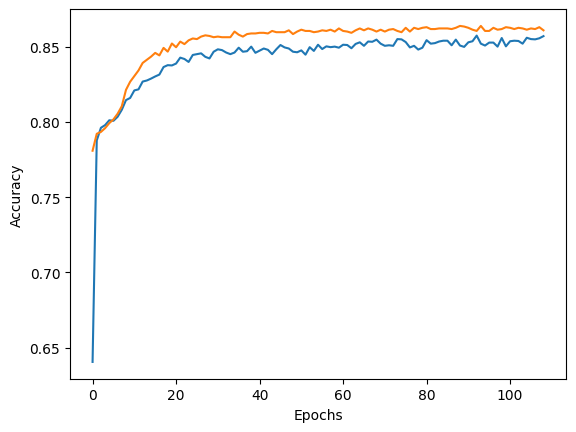

In [43]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()

if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.figure()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()